In [649]:
import nltk
# from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
from glob import glob
from collections import Counter
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
% matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import spacy
import textacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

In [292]:
nlp = spacy.load('en')

In [253]:
class Text(): 
    def __init__(self, filename): 
        self.filename = filename
        self.number = filename.split('_')[0][4:]
        self.label = filename.split('.')[2][2:]
        with open(filename) as f: 
            self.soup = BeautifulSoup(f, 'lxml')
    
    @property
    def text(self): 
        return self.soup.text
    
    @property
    def numWords(self): 
        return len(self.text.split())
    
    @property
    def saids(self): 
        """ Aggregate titles. """
        saids = self.soup.find_all('said')
        return saids

    @property
    def charDict(self): 
        """ Makes a dictionary of character names with lists of things they say. """
        charDict = {}
        for said in self.saids: 
            if said.attrs['who'] not in charDict: 
                charDict[said.attrs['who']] = [said.text]
            else: 
                charDict[said.attrs['who']].append(said.text)
        return charDict
    
    @property
    def stats(self): 
        return pd.Series({char: len(dialogue) 
                          for char, dialogue in self.charDict.items()})
    
    @property
    def topThree(self):
        return self.stats.sort_values(ascending=False)[:3]

In [254]:
filenames = sorted([f for f in glob('../u*.xml')])

In [255]:
texts = [Text(f) for f in filenames]

In [256]:
labels = [text.label for text in texts]

In [257]:
stats = [text.stats for text in texts]

In [258]:
df = pd.DataFrame(stats, index=labels).fillna(0)

In [282]:
n = 9
topChars = df.sum().sort_values(ascending=False)[:n].index
other = df.sum().sort_values()[:-n].index

In [262]:
df2 = df[topChars]

In [263]:
df2['Other'] = df[other].sum(axis=1)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


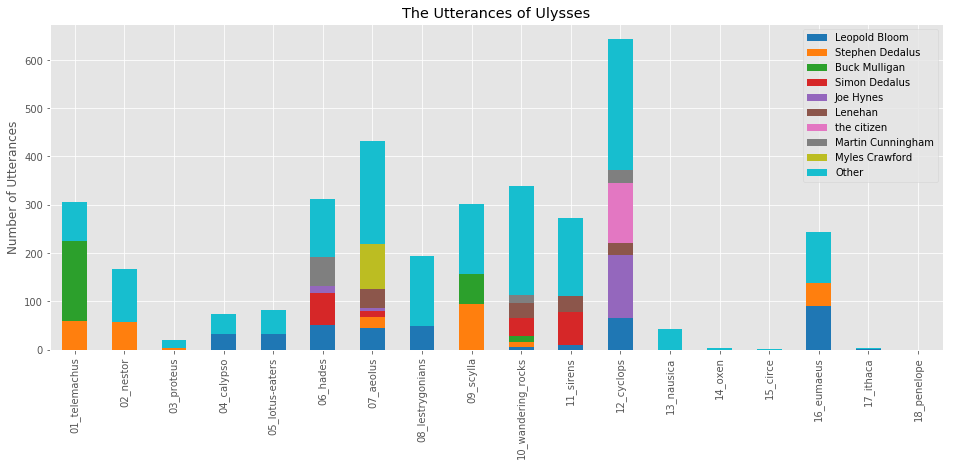

In [281]:
ax = df2.plot(kind='bar', stacked=True, colormap='Vega10', title="The Utterances of Ulysses" )
ax.set_ylabel('Number of Utterances')

In [284]:
allChars = {}
for text in texts: 
    for char in text.charDict: 
        if char not in allChars: 
            allChars[char] = text.charDict[char]
        else: 
            allChars[char] += text.charDict[char]

In [286]:
len(allChars)

199

In [535]:
labels = []
dialogueList = []
for char in allChars: 
    labels.append(char)
    dialogueList.append(allChars[char])

In [536]:
dialogue = {char: ' '.join(dia) for char, dia in allChars.items()}

In [537]:
len(joined)

199

In [339]:
lengths = [len(joined[d]) for d in joined]

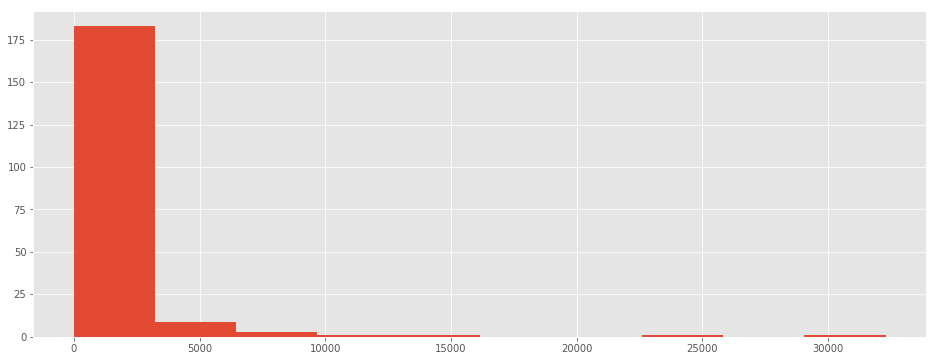

In [342]:
pd.Series(lengths).hist()

In [356]:
verboseChars = {char: joined[char] for char in joined if len(joined[char]) > 5000}

In [357]:
len(verboseChars)

10

In [379]:
[len(verboseChars[char]) for char in verboseChars]

[15870, 32289, 24149, 7109, 5208, 6982, 5270, 6587, 5376, 10624]

In [382]:
# Get the first 5,000 characters (letters) of each text, so that 
# we're comparing the same amount of stuff. 
charSnippets = {char: verboseChars[char][:5000] for char in verboseChars}

In [396]:
labels = list(charSnippets.keys())
docs = list(charSnippets.values())

# PCA of TF-IDF Vectors

In [428]:
tfidf = TfidfVectorizer(use_idf=False, max_features=500)
pca = PCA(n_components=2)

In [429]:
bag = tfidf.fit_transform(docs).todense()

In [430]:
bag.shape

(10, 500)

In [431]:
pcaOut = pca.fit_transform(bag)

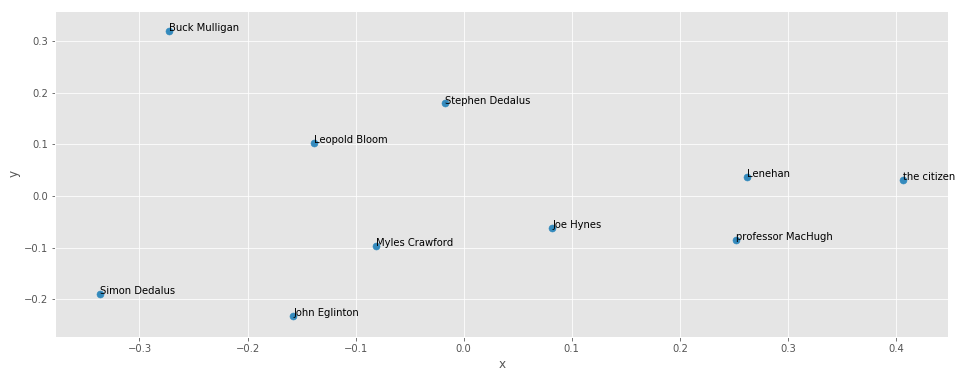

In [434]:
pcaDF = pd.DataFrame([pcaOut[:,0], pcaOut[:,1], labels], index=['x', 'y', 'l']).T
ax = pcaDF.plot.scatter(x='x', y='y', s=50)
ax = pcaDF.apply(lambda x: ax.text(*x),axis=1)

# Semantic Vector Similarity with GloVe Vectors

In [436]:
sdocs = [nlp(doc) for doc in docs]

In [440]:
similarities = [ [doc.similarity(other) for other in sdocs] for doc in sdocs ]
similaritiesDf = pd.DataFrame(similarities, columns=labels, index=labels)

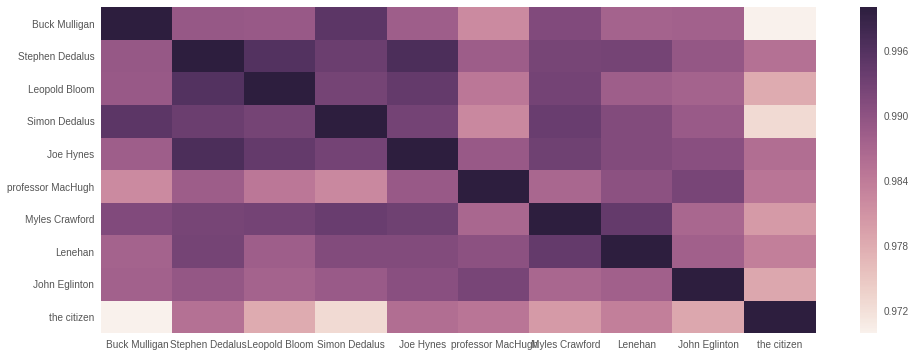

In [444]:
seaborn.heatmap(similaritiesDf)

In [457]:
def plotDendrogram(similarityMatrix):
    linkage = ward(similarityMatrix)
    fig, ax = plt.subplots() # set size
    ax = dendrogram(linkage, orientation="right", labels=labels);

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')

    plt.tight_layout() #show plot with tight layout
    plt.show()

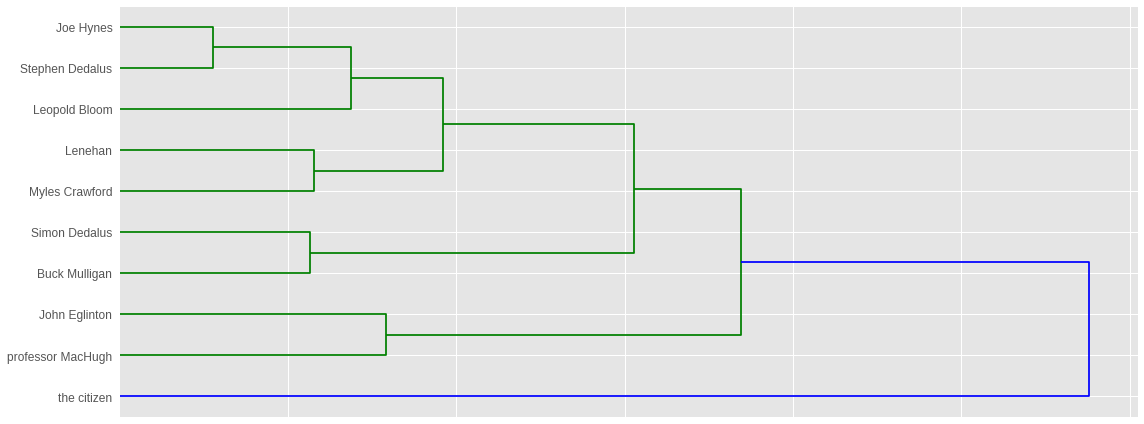

In [458]:
plotDendrogram(similaritiesDf)

# Cosine Document Similarity of TF-IDF Vectors

In [454]:
cs = 1 - cosine_similarity(bag)

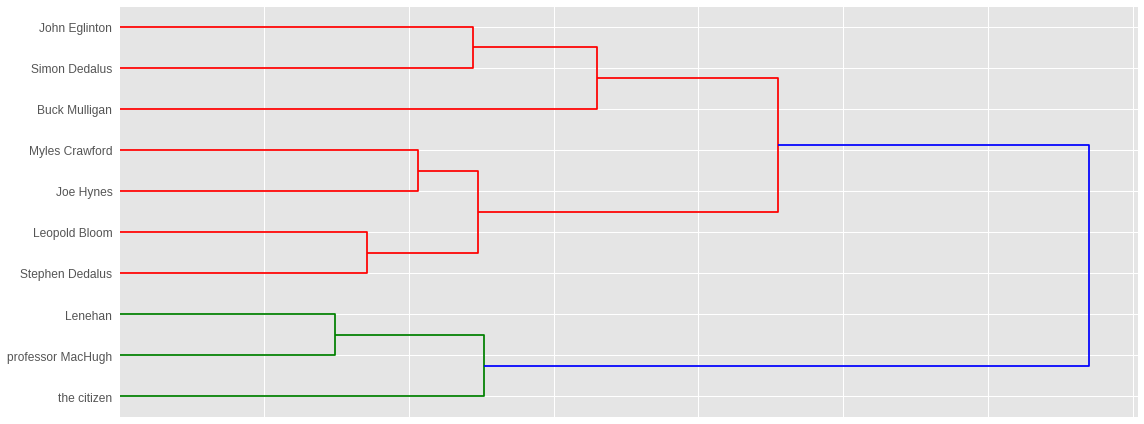

In [459]:
plotDendrogram(cs)

# Extract Statistically Distinguishing Words

(Among the top 500 most frequently used words.) 

In [466]:
tfidfDF = pd.DataFrame(bag, columns=tfidf.get_feature_names(), index=labels)

In [469]:
# Compute the mean frequencies for each word. 
mean = tfidfDF.mean()
# Get their standard deviations. 
std = tfidfDF.std()
# Compute the distance in standard deviations from the mean 
# for each word. 
deviations = abs(tfidfDF - mean) / std
deviations

In [504]:
# Get words that are 2.5 standard deviations away 
# from the mean for each character. 
cutoff = 2.5
for row in deviations.iterrows(): 
    outliers = list(row[1][row[1]>cutoff].index)
    print(row[0], ': ', outliers, '\n')

Buck Mulligan :  ['absurd', 'beastly', 'because', 'dedalus', 'etiquette', 'gentleman', 'jesuit', 'kinch', 'knows', 'mockery', 'mother', 'must', 'only', 'sea', 'thinks'] 

Stephen Dedalus :  ['black', 'brawn', 'dark', 'deasy', 'fear', 'from', 'mine', 'servant', 'sir', 'thank', 'three', 'understand'] 

Leopold Bloom :  ['awfully', 'councillor', 'coy', 'excuse', 'fact', 'idea', 'just', 'keep', 'keyes', 'keys', 'metempsychosis', 'part', 'pussens', 'run', 'wants'] 

Simon Dedalus :  ['back', 'ben', 'blessed', 'child', 'christ', 'dick', 'died', 'glass', 'hold', 'little', 'looked', 'man', 'many', 'ned', 'poor', 'simple', 'stand', 'straight', 'whatever', 'wouldn'] 

Joe Hynes :  ['again', 'alf', 'ay', 'citizen', 'field', 'terry', 'truth'] 

professor MacHugh :  ['fitzgibbon', 'heard', 'lord', 'loyal', 'shore', 'speech', 'taylor', 'words'] 

Myles Crawford :  ['bite', 'bushe', 'forget', 'gallaher', 'gumley', 'in', 'mouth', 'murder', 'north', 'ohio', 'place', 'press', 'psha', 'right', 'time', 't

# Readability Statistics

In [581]:
# Parse with SpaCy
sdocs = {char: nlp(dia) for char, dia in dialogue.items()}

In [585]:
# Analyze only those characters with more than 500 words of dialogue. 
topSdocs = {char: dia for char, dia in sdocs.items() if len(dia) > 500}
labels = [char for char in topSdocs]

In [557]:
# Parse with Textacy
tdocs = [textacy.Doc(doc, metadata=char) for char, doc in topSdocs.items()]

In [558]:
# Compute a variety of readability statistics. 
readability = {doc.metadata: textacy.text_stats.readability_stats(doc)
               for doc in tdocs}

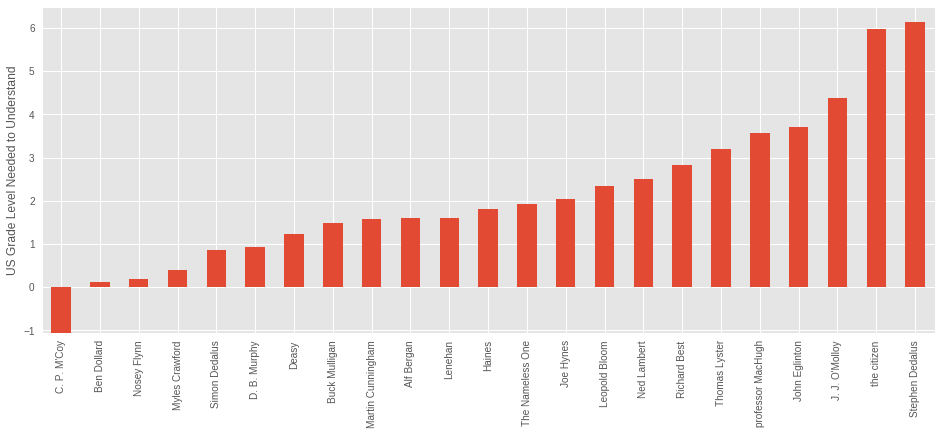

In [561]:
ax = pd.DataFrame(readability).T['automated_readability_index'].sort_values().plot(kind='bar')
ax.set_ylabel('US Grade Level Needed to Understand')

# Topic Modeling with Non-Negative Matrix Factorization

In [598]:
doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
        (doc.to_terms_list(named_entities=True, as_strings=True, filter_punct=True)
         for doc in tdocs),
        weighting='tfidf', normalize=True, smooth_idf=True, min_df=2, max_df=0.95)
model = textacy.tm.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
topics = []
for topic_idx, top_terms in model.top_topic_terms(id2term, top_n=10):
    print('topic', topic_idx, ':', '   '.join(top_terms))
    topics.append(' '.join(top_terms))

topic 0 : '   not   god   ireland   bloom   come   irish   good   like   tell
topic 1 : wilde   not   hamlet   shakespeare   french   hughes   piper   mean   write   hue
topic 2 : ned   myles   bushe   roman   think   a.   american   flood   edward   european
topic 3 : joe   troy   bloody   chicken   ―show   cod   good health   pill   ―who   lane
topic 4 : u.   breen   hang   terry   p   dignam   round   thousand   pound   bloody
topic 5 : simon   bob   soul   barabbas   judas   writ   remember   love   ―go   god
topic 6 : bugger   sinn fein   fifty   dublin   nelson   seven   adam   aristotle   plato   nine
topic 7 : sin   o'connell   english   end   moment   englishman   england   letter   vote   o'rourke
topic 8 : mr   kilkenny   poet   certainly   shakespeare   dedalus   goethe   mr dedalus   madden   gentleman
topic 9 : reuben   father   ―it   poison   germany   quay   clare   virag   j.   hungary


In [599]:
topics

["' not god ireland bloom come irish good like tell",
 'wilde not hamlet shakespeare french hughes piper mean write hue',
 'ned myles bushe roman think a. american flood edward european',
 'joe troy bloody chicken ―show cod good health pill ―who lane',
 'u. breen hang terry p dignam round thousand pound bloody',
 'simon bob soul barabbas judas writ remember love ―go god',
 'bugger sinn fein fifty dublin nelson seven adam aristotle plato nine',
 "sin o'connell english end moment englishman england letter vote o'rourke",
 'mr kilkenny poet certainly shakespeare dedalus goethe mr dedalus madden gentleman',
 'reuben father ―it poison germany quay clare virag j. hungary']

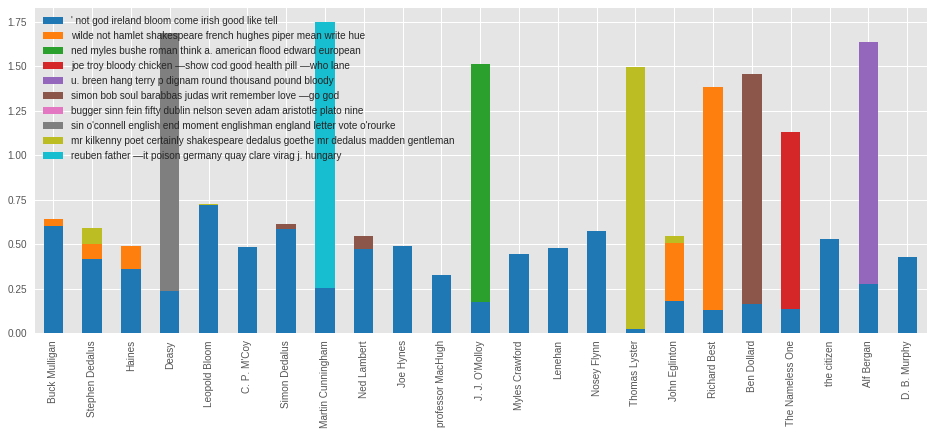

In [603]:
charTopicsDF = pd.DataFrame(doc_topic_matrix, columns=topics, index=labels)
charTopicsDF.plot(kind='bar', colormap='Vega10', stacked=True)

# Clustering Topic-Fitted Data

In [640]:
km = KMeans(n_clusters=3)

In [641]:
kmOut = km.fit_transform(charTopicsDF)
assignments = kmOut.argmax(axis=1)

In [642]:
charGroups = {}
for n in set(assignments): 
    charGroups[n] = []
    for i in range(len(assignments)):
        if assignments[i]==n: 
            charGroups[n].append(labels[i]) 

In [647]:
for key, val in charGroups.items(): 
    val = [name.replace('\xa0', ' ') for name in val] # Make it easier to read. 
    print('Group %s: %s' % (key, val), '\n')

Group 1: ['Buck Mulligan', 'Haines', 'Leopold Bloom', "C. P. M'Coy", 'Simon Dedalus', 'Martin Cunningham', 'Ned Lambert', 'Joe Hynes', 'professor MacHugh', 'Myles Crawford', 'Lenehan', 'Nosey Flynn', 'the citizen', 'Alf Bergan', 'D. B. Murphy'] 

Group 2: ['Stephen Dedalus', 'Deasy', "J. J. O'Molloy", 'Thomas Lyster', 'John Eglinton', 'Richard Best', 'Ben Dollard', 'The Nameless One'] 

